# Classification of human activity from motion sensor data

## Description

This dataset includes time-series data generated by accelerometer and gyroscope sensors (attitude, gravity, userAcceleration, and rotationRate). 

- Data was collected with an iPhone 6s kept in the participant's front pocket using *SensingKit* which collects information from *Core Motion* framework on iOS devices. 
- All data collected in 50Hz sample rate. 
- A total of 24 participants in a range of gender, age, weight, and height were recorded
- Participants performed 6 activities in 15 trials in the same environment and conditions: *downstairs, upstairs, walking, jogging, sitting,* and *standing*. 

### Task

- The primary task is to **build a classifier for human activity** based on motion data coming from the mobile device. Also, make sure that you construct a testing set based on different persons in order to test whether the model generalizes well.

- The secondary task is to **build a fingerprint generator** that would allow for identification of a person using (wearing) a mobile device\*


 \* *This dataset was taken from the project that aims to build countermeasures for the second task's goal. It tries to anonymise motion data\** so that the identification is not possible but the data is still usable for "safe tasks" like activity recognition. The complexity of such anonymisation model is beyond today's lesson but it is still useful to think of possible solutions for such a problem.*

 \** *The dataset is anonymised (names of participants and unknown)* 


### Acknowledgement

Mohammad Malekzadeh, Richard G.Clegg, Andrea Cavallaro and Hamed Haddadi - *Mobile Sensor Data Anonymization*

[GitHub repository](https://github.com/mmalekzadeh/motion-sense)

## Imports & Drive mount

In [ ]:
%tensorflow_version 2.x
%matplotlib inline

import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [ ]:
matplotlib.rcParams['figure.figsize'] = (15, 6)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Dataset loading & basic analysis

In [ ]:
import zipfile

MOTION_DATA = '/content/drive/My Drive/ml-college/time-series-analysis/data/motion-sensing'
DATA_FOLDER = '/content/MotionData'

with zipfile.ZipFile(MOTION_DATA + '/A_DeviceMotion_data.zip', 'r') as zip_ref:
    zip_ref.extractall(DATA_FOLDER)

In [ ]:
walking_sample = pd.read_csv(DATA_FOLDER + '/A_DeviceMotion_data/wlk_7/sub_1.csv')
walking_sample

,Unnamed: 0,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,0,-1.711140,-1.429168,-2.591433,-0.139767,0.989987,0.019745,-0.350593,-0.511691,-0.865217,0.091702,0.415881,0.093689
1,1,-1.787917,-1.414171,-2.630956,-0.152324,0.987759,0.033602,-0.550553,-2.243217,-0.582409,0.367412,0.004566,-0.106082
2,2,-1.897323,-1.399331,-2.706668,-0.161610,0.985336,0.054729,-0.931014,-1.358033,-0.503947,0.172093,-0.217483,-0.163387
3,3,-2.018375,-1.383279,-2.813421,-0.168058,0.982470,0.080680,-1.304668,-0.541368,-0.346302,0.004957,-0.237566,-0.019080
4,4,-2.124395,-1.364054,-2.913092,-0.174613,0.978705,0.107922,-1.278349,-0.434722,-0.398598,-0.040292,-0.241461,0.015201
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5434,5434,2.740007,-0.813391,2.707558,0.268549,0.726621,0.632380,-4.759731,3.035508,-1.614411,-0.690515,0.160006,-0.301676
5435,5435,2.855015,-0.747426,2.792285,0.207323,0.679753,0.703529,-3.553162,2.566744,-1.584018,-0.628969,0.368785,-0.986305
5436,5436,2.934443,-0.706561,2.835642,0.156434,0.649222,0.744338,-1.892946,2.297347,-0.922597,-0.323685,0.392786,-0.913802
5437,5437,2.977191,-0.671725,2.868442,0.128106,0.622337,0.772195,-1.976241,0.373779,-0.930328,-0.129754,0.223900,-0.717584


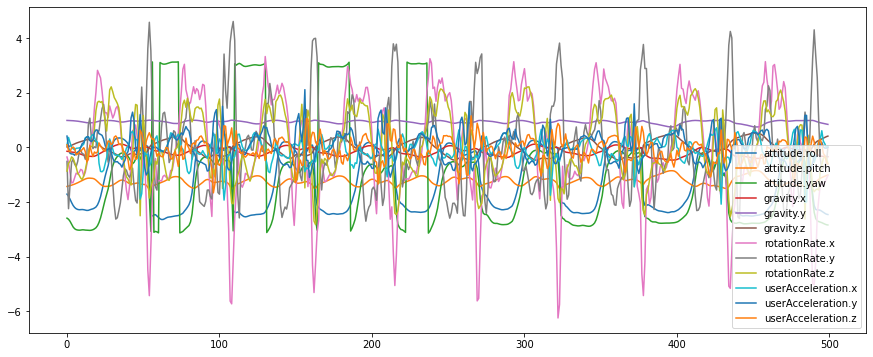

In [ ]:
walking_sample.iloc[:500,1:].plot()

In [ ]:
full_dataset = []
for dirpath, dirnames, filenames in tqdm(list(os.walk(DATA_FOLDER + '/A_DeviceMotion_data'))):
    for filename in filenames:
        motion_data = pd.read_csv(dirpath + os.sep + filename).iloc[:,1:]       
        subject_code = int(filename.split('.')[0].split('_')[1]) 
        activity_code = dirpath.split(os.sep)[-1].split('_')[0]
        full_dataset.append((activity_code, subject_code, motion_data))

In [ ]:
from collections import Counter

activities, participants, motion_data = zip(*full_dataset)

print(Counter(activities))
activities = set(activities)

print(Counter(participants))
participants = set(participants)

Counter({'ups': 72, 'wlk': 72, 'dws': 72, 'sit': 48, 'std': 48, 'jog': 48})
Counter({15: 15, 6: 15, 3: 15, 8: 15, 14: 15, 16: 15, 20: 15, 13: 15, 11: 15, 4: 15, 12: 15, 10: 15, 17: 15, 7: 15, 18: 15, 21: 15, 19: 15, 24: 15, 23: 15, 22: 15, 1: 15, 5: 15, 9: 15, 2: 15})


^ As described at the beginning, the dataset contains 6 activities, 24 participants and 15 trials for 
each participant.

Let's build some dictionaries for simple selection of data and do basic analysis of the motion data inside.

In [ ]:
all_trials = pd.concat(motion_data)

In [ ]:
trials_by_activity = {act: [] for act in activities}
trials_by_participant = {p: [] for p in participants}

for act, p, trial in full_dataset:
    trials_by_activity[act].append((p, trial))
    trials_by_participant[p].append((act, trial))

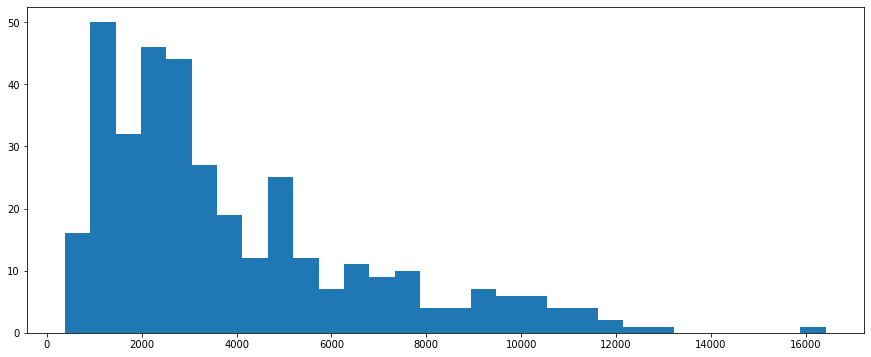

In [ ]:
plt.hist([len(trial) for trial in motion_data], bins=30)
plt.show()

^ It seems like the most of the tome series are arount 60 seconds long with one outlier which is ~5min long.

In [ ]:
all_trials.isna().sum()

attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

^ Also, there are no missing values.

In [ ]:
all_trials.describe().T

,count,mean,std,min,25%,50%,75%,max
attitude.roll,1412865.0,-0.176043,1.566652,-3.141590,-1.480050,0.122218,0.876360,3.141579
attitude.pitch,1412865.0,-0.986649,0.494086,-1.569974,-1.358278,-1.181032,-0.623393,1.567175
attitude.yaw,1412865.0,-0.149269,1.544769,-3.141588,-1.277552,-0.135653,0.829143,3.141584
gravity.x,1412865.0,0.042134,0.338830,-0.999822,-0.172530,0.019914,0.272144,0.999998
gravity.y,1412865.0,0.754722,0.333265,-0.999993,0.583793,0.924999,0.977503,1.000000
gravity.z,1412865.0,-0.138825,0.428323,-0.999999,-0.392241,-0.096902,0.084882,0.981312
rotationRate.x,1412865.0,0.005321,1.292916,-17.365788,-0.286030,-0.000394,0.116321,10.468056
rotationRate.y,1412865.0,0.014581,1.226470,-18.414406,-0.166986,0.000325,0.231271,17.543121
rotationRate.z,1412865.0,0.012760,0.808041,-12.151242,-0.097333,0.000177,0.113328,11.436243
userAcceleration.x,1412865.0,-0.003911,0.328209,-6.369264,-0.047513,0.000891,0.044284,7.120793


^ The data values seems to be reasonable, no wild outliers and expected ranges.
- Note that *attitude* and *rotationRate* are **angular quantities**, we should consider that in the normalization (if we decide to do some normalization)

The dataset does not need too much normalization but let's do it for the sake of example.

std 19


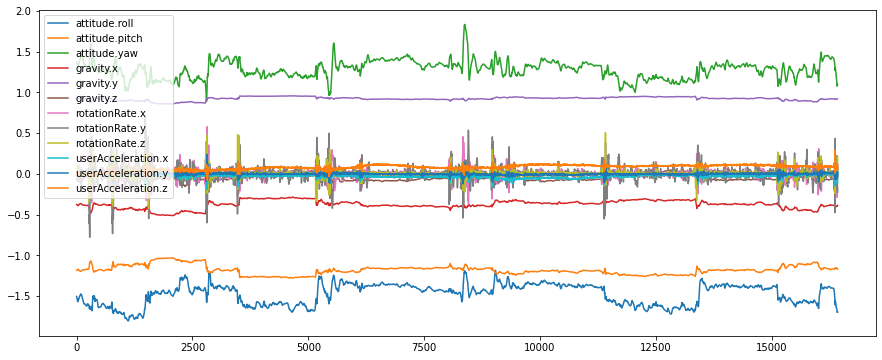

In [ ]:
for act, p, data in full_dataset:
    if len(data) >= 16000:
        print(act, p)
        data.plot()
        break

^ Also, the 5min outlier does not look any suspicious. No missing values at the end or similar irregularities.

## Data Normalization

We are dealing with physical quantities described by 3D vectors or angles. Let's normalize accordingly.

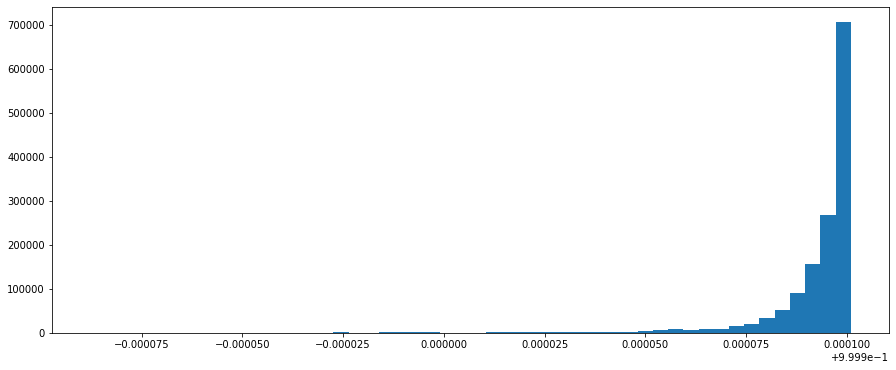

In [ ]:
plt.hist(
    np.linalg.norm(all_trials.filter(regex="gravity.*"), axis=-1),    
    bins=50
)
plt.show()

^ Direction of gravity vector is normalized already (all norms are very close to 1.0)

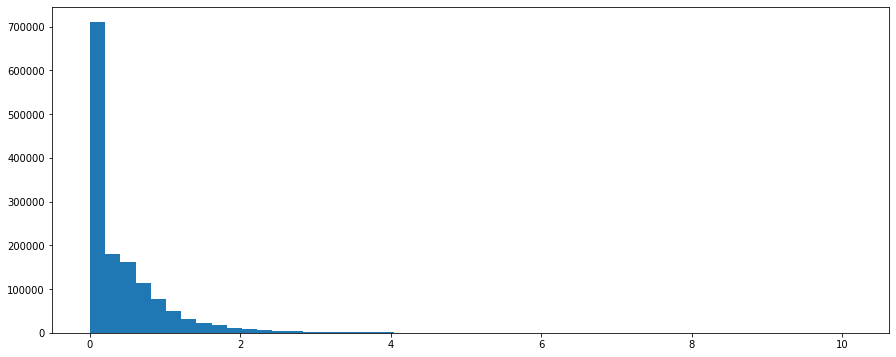

0.42538013165123095


In [ ]:
acc_norms = np.linalg.norm(all_trials.filter(regex="userAcceleration*"), axis=-1)
plt.hist(
    acc_norms,    
    bins=50
)
plt.show()
print(np.mean(acc_norms))

^ User accelerations are in Gs and most of the time the norm is around zero. Let's use the mean of norms for normalization (simply divide all values by it)

In [ ]:
angular_quantities = all_trials.filter(regex="attitude.*|rotationRate.*")
angular_quantities.describe().T

,count,mean,std,min,25%,50%,75%,max
attitude.roll,1412865.0,-0.176043,1.566652,-3.141590,-1.480050,0.122218,0.876360,3.141579
attitude.pitch,1412865.0,-0.986649,0.494086,-1.569974,-1.358278,-1.181032,-0.623393,1.567175
attitude.yaw,1412865.0,-0.149269,1.544769,-3.141588,-1.277552,-0.135653,0.829143,3.141584
rotationRate.x,1412865.0,0.005321,1.292916,-17.365788,-0.286030,-0.000394,0.116321,10.468056
rotationRate.y,1412865.0,0.014581,1.226470,-18.414406,-0.166986,0.000325,0.231271,17.543121
rotationRate.z,1412865.0,0.012760,0.808041,-12.151242,-0.097333,0.000177,0.113328,11.436243


^ Angular quantities are in radians and we should divide it by PI (or divide by standard deviation if we want to enforce less pronounced axes) 

In [ ]:
acc_mean = np.mean(acc_norms)

def normalize_trial(trial):        
    att = trial.filter(regex="attitude.*") / np.pi
    gravity = trial.filter(regex="gravity.*")
    rot_rate = trial.filter(regex="rotationRate.*") / np.pi
    u_accs = trial.filter(regex="userAcceleration.*") / acc_mean
    return pd.concat([att, gravity, rot_rate, u_accs], axis=1)

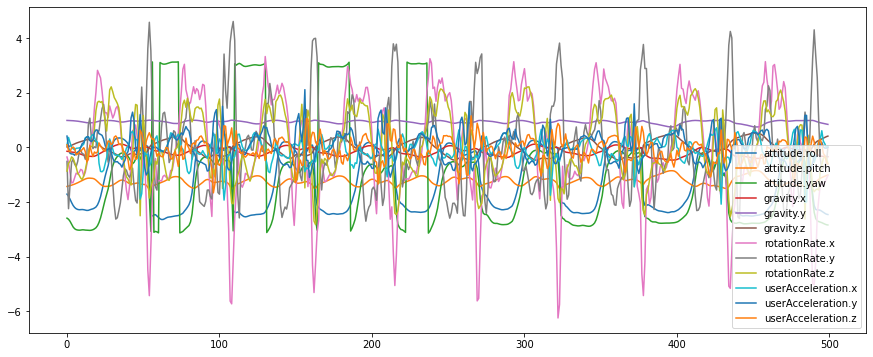

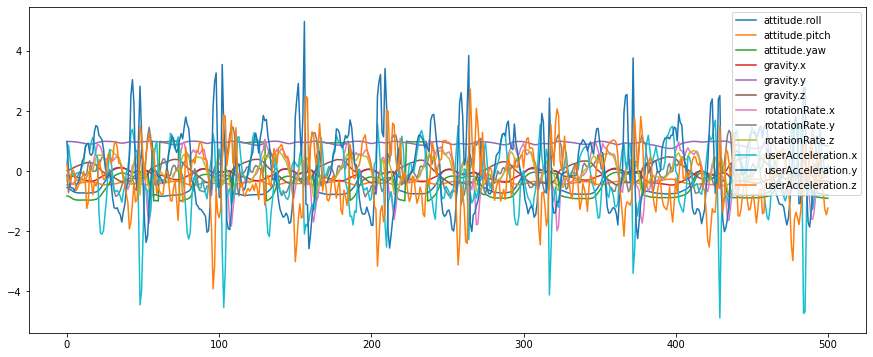

In [ ]:
walking_sample.iloc[:500,1:].plot()
normalize_trial(walking_sample).loc[:500,:].plot()

## Training & testing set creation - Classification of activity

As there are 24 participants in the data we definitely should select testing set according to participants so we know that the model generalized to unseen people.

*Note: Is this enough? Are there any other attributes that should be considered for the robust test set?*

In [ ]:
TESTING_MARK = 4

shuffled_partic = list(participants)
random.shuffle(shuffled_partic)

training_participants = shuffled_partic[:-TESTING_MARK]
testing_participants = shuffled_partic[-TESTING_MARK:]

We will split each trial time series to chunks as we do not expect the model to tell the prediction after the whole minute of data. It should get it way faster. `SEQ_LEN` becomes a hyperparameter for the model.

In [ ]:
SEQ_LEN = 200
STRIDE = SEQ_LEN // 2

We also need to index categories for the target values

In [ ]:
labels = {k: i for i, k in enumerate(activities)}
sorted_labels = [l for l, i in sorted(labels.items(), key=lambda x: x[1])]
labels

{'dws': 1, 'jog': 3, 'sit': 2, 'std': 5, 'ups': 4, 'wlk': 0}

Now, let's build normalized datasets

In [ ]:
from tensorflow.keras.utils import to_categorical

def get_activity_dataset(selected_participants, seq_len, stride):
    X = []
    Y = []    

    for p in tqdm(selected_participants):
        trials = trials_by_participant[p]
        for act, trial in trials:
            indices = np.array(range((len(trial) - seq_len) // stride)) * stride        
            for i in indices:                
                X.append(normalize_trial(trial).values[i:i+seq_len,:])
                Y.append(to_categorical(labels[act], len(labels)))

    return np.array(X), np.array(Y)
  

In [ ]:
act_training_X, act_training_Y = get_activity_dataset(training_participants, SEQ_LEN, STRIDE)

print(act_training_X.shape)
print(act_training_Y.shape)


(11163, 200, 12)
(11163, 6)


In [ ]:
act_testing_X, act_testing_Y = get_activity_dataset(testing_participants, SEQ_LEN, STRIDE)

print(act_testing_X.shape)
print(act_testing_Y.shape)


(2069, 200, 12)
(2069, 6)


Also let's prepare an evaluation routine for the upcoming models. Simple confusion matrix should be enough.

In [ ]:
from sklearn.metrics import confusion_matrix

def evaluate(model, eval_set_X, eval_set_Y):
    model.evaluate(eval_set_X, eval_set_Y)
    print()
    y_pred = model.predict(eval_set_X)    
    cm = confusion_matrix(
        np.argmax(eval_set_Y, axis=-1), 
        np.argmax(y_pred, axis=-1),    
    )
    print(cm)

## LSTM Model for activity classification

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Input, Dense, Dropout

inputs = Input(shape=(None, act_training_X.shape[-1]))
x = Dense(64, activation='relu')(inputs)
x = Dropout(0.1)(x)
x = LSTM(32, return_sequences=True)(x)
x = Dropout(0.1)(x)
x = LSTM(32, return_sequences=False)(x)
outputs = Dense(act_training_Y.shape[-1], activation='softmax')(x)

lstm_model = Model(inputs, outputs)
lstm_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

**!!!! IMPORTANT !!!!** validation_data needs to be a TUPLE not list! [bug in tensorflow](https://github.com/tensorflow/tensorflow/issues/39370)

In [ ]:
lstm_model.fit(act_training_X, act_training_Y, validation_data=(act_testing_X, act_testing_Y), epochs=10)

Epoch 1/10
349/349 [==============================] - 7s 21ms/step - loss: 0.4888 - accuracy: 0.8336 - val_loss: 0.5097 - val_accuracy: 0.8555
Epoch 2/10
349/349 [==============================] - 7s 19ms/step - loss: 0.2875 - accuracy: 0.9004 - val_loss: 0.4048 - val_accuracy: 0.8748
Epoch 3/10
349/349 [==============================] - 7s 19ms/step - loss: 0.2049 - accuracy: 0.9347 - val_loss: 0.5395 - val_accuracy: 0.8410
Epoch 4/10
349/349 [==============================] - 7s 19ms/step - loss: 0.1478 - accuracy: 0.9569 - val_loss: 0.4123 - val_accuracy: 0.9135
Epoch 5/10
349/349 [==============================] - 7s 19ms/step - loss: 0.1191 - accuracy: 0.9663 - val_loss: 0.4241 - val_accuracy: 0.9058
Epoch 6/10
349/349 [==============================] - 7s 19ms/step - loss: 0.0978 - accuracy: 0.9710 - val_loss: 0.4445 - val_accuracy: 0.9038
Epoch 7/10
349/349 [==============================] - 7s 19ms/step - loss: 0.0879 - accuracy: 0.9742 - val_loss: 0.4857 - val_accuracy: 0.8966

In [ ]:
lstm_model.save_weights("lstm_64_32.hdf")

### Model evaluation

In [ ]:
evaluate(lstm_model, act_testing_X, act_testing_Y)
print(sorted_labels)

65/65 [==============================] - 1s 10ms/step - loss: 0.4479 - accuracy: 0.9178

[[489   0   0   2   4   2]
 [ 18 110   0   2  32   0]
 [  0   0 558   0   0   0]
 [  0   1   0 182   3   0]
 [ 47  25   4   0 127   0]
 [  1   0  28   0   1 433]]
['wlk', 'dws', 'sit', 'jog', 'ups', 'std']


Let's see how the LSTM model behaves on the whole trial sequence.
- First, we need a model that gives a continuous prediction (i.e. `return_sequences = True` for the last recurrent layer)
- Then, we can reuse already trained model by loading its weights

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Input, Dense, Dropout

inputs = Input(shape=(None, act_training_X.shape[-1]))
x = Dense(64, activation='relu')(inputs)
x = Dropout(0.1)(x)
x = LSTM(32, return_sequences=True)(x)
x = Dropout(0.1)(x)
x = LSTM(32, return_sequences=True)(x)
outputs = Dense(act_training_Y.shape[-1], activation='softmax')(x)

lstm_model_c = Model(inputs, outputs)
lstm_model_c.load_weights("lstm_64_32.hdf")

- Finally, let's visualize predictions for all classes at once throughout the whole trial

In [ ]:
for p in testing_participants[:2]:
    trials = trials_by_participant[p]
    for act, trial in trials:
        prediction = lstm_model_c.predict(np.expand_dims(normalize_trial(trial).values, axis=0))[0]      
        print("GT: " + act)        
        fig, axes = plt.subplots(2, 1, sharex=True, figsize=(25, 5)) 
        axes[0].plot(trial.values)
        axes[1].imshow(prediction.T, aspect='auto', interpolation='none')
        plt.yticks(range(6), labels=sorted_labels)
        plt.show()             

## 1D Convolutional network with global pooling

Convolutional network are usually applied on fixed-sized images/data but they can be applied on image/data of arbitrary size. 

Variable-sized input will result in variable-sized output of the convolution layers so we need to add some mechanism that would make the variable-sized output fixed for the classification output. 

We can use a recurrent layer as in the previous model but we can also just aggregate all outputs into one with a *Global Pooling* layer. 

In Keras, we can select from *Max* or *Average* pooling layers. Let's try the max one.

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalMaxPool1D, Dropout

inputs = Input(shape=act_training_X.shape[-2:])
x = Conv1D(32, 3, activation='relu')(inputs)
x = Dropout(0.1)(x)
x = MaxPool1D()(x)
x = Conv1D(32, 3, activation='relu')(x)
x = Dropout(0.1)(x)
x = MaxPool1D()(x)
x = Conv1D(32, 3, activation='relu')(x)
x = Dropout(0.1)(x)
x = MaxPool1D()(x)
x = Conv1D(32, 3, activation='relu')(x)
x = Dropout(0.1)(x)
x = GlobalMaxPool1D()(x)
outputs = Dense(act_training_Y.shape[-1], activation='softmax')(x)

cnn_model = Model(inputs, outputs)
cnn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 12)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 198, 32)           1184      
_________________________________________________________________
dropout_4 (Dropout)          (None, 198, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 99, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 97, 32)            3104      
_________________________________________________________________
dropout_5 (Dropout)          (None, 97, 32)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 32)           

^ Notice how time dimension correctly disappears after the global pooling layer.

In [ ]:
cnn_model.fit(act_training_X, act_training_Y, validation_data=(act_testing_X, act_testing_Y), epochs=10)

Epoch 1/10
349/349 [==============================] - 2s 5ms/step - loss: 0.0174 - accuracy: 0.9946 - val_loss: 0.4664 - val_accuracy: 0.9169
Epoch 2/10
349/349 [==============================] - 2s 5ms/step - loss: 0.0175 - accuracy: 0.9948 - val_loss: 0.5463 - val_accuracy: 0.9232
Epoch 3/10
349/349 [==============================] - 2s 5ms/step - loss: 0.0175 - accuracy: 0.9949 - val_loss: 0.4483 - val_accuracy: 0.9362
Epoch 4/10
349/349 [==============================] - 2s 5ms/step - loss: 0.0162 - accuracy: 0.9951 - val_loss: 0.4804 - val_accuracy: 0.9265
Epoch 5/10
349/349 [==============================] - 2s 5ms/step - loss: 0.0143 - accuracy: 0.9961 - val_loss: 0.5270 - val_accuracy: 0.9391
Epoch 6/10
349/349 [==============================] - 2s 5ms/step - loss: 0.0126 - accuracy: 0.9958 - val_loss: 0.5209 - val_accuracy: 0.9149
Epoch 7/10
349/349 [==============================] - 2s 5ms/step - loss: 0.0145 - accuracy: 0.9953 - val_loss: 0.4500 - val_accuracy: 0.9251
Epoch 

In [ ]:
evaluate(cnn_model, act_testing_X, act_testing_Y)

65/65 [==============================] - 0s 3ms/step - loss: 0.5217 - accuracy: 0.9309

[[473   1   0   0  22   1]
 [  7 129   0   1  25   0]
 [  0   0 558   0   0   0]
 [  0   1   0 185   0   0]
 [ 15  33   0   0 155   0]
 [  3   0  34   0   0 426]]


We got to comparable results but in much lower training time and less epochs.
Now, let's see how the model performs on a different sized input.

*Note: The model is compiled to accept the fixed-sized input so it will complain but it should give right resluts unless the input sequence is too short for the depth of the model. Then it will crash.*

*Note 2: If you want to get rid of the warning, compile the model with free temporal dimention input layer:* 

`Input(shape=(None, act_training_X.shape[-1]))`


In [ ]:
act_testing2_X, act_testing2_Y = get_activity_dataset(testing_participants, 100, 50)

print(act_testing2_X.shape)
print(act_testing2_Y.shape)


(4288, 100, 12)
(4288, 6)


In [ ]:
evaluate(cnn_model, act_testing2_X, act_testing2_Y)

143/143 [==============================] - 0s 3ms/step - loss: 0.3055 - accuracy: 0.9202

[[ 441    0    6    1    8    9]
 [   0  940    3    0    5    0]
 [   6    0  343   10   32   16]
 [   0    0    0 1204    0    0]
 [   0   17   47    1  417   23]
 [   4    8   58    0  111  863]]


In [ ]:
act_testing3_X, act_testing3_Y = get_activity_dataset(testing_participants, 400, 50)

print(act_testing2_X.shape)
print(act_testing2_Y.shape)


(4573, 100, 12)
(4573, 6)


In [ ]:
evaluate(cnn_model, act_testing3_X, act_testing3_Y)

132/132 [==============================] - 0s 3ms/step - loss: 0.2415 - accuracy: 0.9333

[[ 394    0   15    0    8    0]
 [   0  879    8    0   13    0]
 [   0    0  294    0   41    0]
 [   0    0    0 1156    0    0]
 [   0    0   35    0  393    5]
 [   0    0   34    0  122  816]]


The model works also for shorter and longer inputs and it seems it performs slightly better for longer inputs.

Unfortunately, we cannot visualize the outputs throughout the whole trial sequence as in the LSTM example as the model internally pools its outputs. However, it is possible to split the model into two parts and put a sliding window with some Hann-like window function in the middle (similar to STFT). Try it yourself!

In [ ]:
del act_training_X
del act_training_Y

## Participant identification / Fingerprint generator

First, let's look at the metadata we have for each participant:

In [ ]:
subject_info = pd.read_csv(MOTION_DATA + '/data_subjects_info.csv')
subject_info

,code,weight,height,age,gender
0,1,102,188,46,1
1,2,72,180,28,1
2,3,48,161,28,0
3,4,90,176,31,1
4,5,48,164,23,0
5,6,76,180,28,1
6,7,62,175,30,0
7,8,52,161,24,0
8,9,93,190,32,1
9,10,72,164,31,0


For the secondary task (identification of a user using the motion data), there are plenty of approaches we can select from: 
- For example, we can build a multivariate regression model and try to predict each quantity (age, weight or height) and even add a gender classifier. 
- Out of that, we can build some locally-similar hashing function and identify a person based on that.

Or we can let the model learn the best representation for person identification task and use that as our hash/fingerprint. Let's try that!

First, let's build the training dataset for an auxilary task of identification the right participant. Simple *Motion Data -> N classes* classification model.

In [ ]:
def get_identification_dataset(selected_participants, seq_len, stride):
    X = []
    Y = []
    p_labels = []
    act_labels = []

    for p in tqdm(selected_participants):
        trials = trials_by_participant[p]
        for act, trial in trials:
            indices = np.array(range((len(trial) - seq_len) // stride)) * stride        
            for i in indices:
                X.append(normalize_trial(trial).values[i:i+seq_len,:])
                Y.append(to_categorical(p - 1, num_classes=24))
                p_labels.append(p)
                act_labels.append(act)

    return np.array(X), np.array(Y), np.array(p_labels), act_labels

In [ ]:
id_training_X, id_training_Y, _, _ = get_identification_dataset(training_participants, SEQ_LEN, STRIDE)

print(id_training_X.shape)
print(id_training_Y.shape)


(11163, 200, 12)
(11163, 24)


^ We have 24 classes (in one-hot representation) 4 classes wil not be used as they are in the testing set.

Let's prepare the testing dataset for later use as well. Also, let's remember activity class for each testing sample.

**We do not expect the model to correctly classify the testing participants** as none of their samples were in the training set. The reason for this weird architecture is that the **auxilary task provides a training signal for the *encoder* model** that will be later used in an unsupervised manner.

In [ ]:
id_testing_X, id_testing_Y, p_labels, act_labels = get_identification_dataset(testing_participants, SEQ_LEN, STRIDE)

print(id_training_X.shape)
print(id_training_Y.shape)


(11163, 200, 12)
(11163, 24)


Now, let's define the model:
- First, the encoder. The encoder will be a similar 1D convolutional network with one additional dense layer at the top that will serve as a fingerprint generator.

In [ ]:
inputs = Input(shape=(None, id_training_X.shape[-1]))
x = Conv1D(32, 3, activation='relu')(inputs)
x = Dropout(0.1)(x)
x = MaxPool1D()(x)
x = Conv1D(32, 3, activation='relu')(x)
x = Dropout(0.1)(x)
x = MaxPool1D()(x)
x = Conv1D(64, 3, activation='relu')(x)
x = Dropout(0.1)(x)
x = MaxPool1D()(x)
x = Conv1D(64, 3, activation='relu')(x)
x = Dropout(0.1)(x)
x = GlobalMaxPool1D()(x)
outputs = Dense(128, activation='relu')(x)

encoder_model = Model(inputs, outputs)
encoder_model.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, None, 12)]        0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, None, 32)          1184      
_________________________________________________________________
dropout_24 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, None, 32)          3104      
_________________________________________________________________
dropout_25 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, None, 32)        

Second, we wrap the model into a standard multi-class classifier.

In [ ]:
inputs = Input(shape=(None, id_training_X.shape[-1]))
enc = encoder_model(inputs)

outputs = Dense(24, activation='softmax')(enc)

id_model = Model(inputs, outputs)
id_model.compile(
    optimizer='rmsprop', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'],    
)
id_model.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, None, 12)]        0         
_________________________________________________________________
functional_23 (Functional)   (None, 128)               31168     
_________________________________________________________________
dense_14 (Dense)             (None, 24)                3096      
Total params: 34,264
Trainable params: 34,264
Non-trainable params: 0
_________________________________________________________________


In [ ]:
id_model.fit(id_training_X, id_training_Y, epochs=20)

Epoch 1/20
349/349 [==============================] - 2s 5ms/step - loss: 1.9966 - accuracy: 0.3750
Epoch 2/20
349/349 [==============================] - 2s 5ms/step - loss: 1.0384 - accuracy: 0.6553
Epoch 3/20
349/349 [==============================] - 2s 5ms/step - loss: 0.6874 - accuracy: 0.7726
Epoch 4/20
349/349 [==============================] - 2s 5ms/step - loss: 0.4986 - accuracy: 0.8331
Epoch 5/20
349/349 [==============================] - 2s 5ms/step - loss: 0.3932 - accuracy: 0.8691
Epoch 6/20
349/349 [==============================] - 2s 5ms/step - loss: 0.3272 - accuracy: 0.8947
Epoch 7/20
349/349 [==============================] - 2s 5ms/step - loss: 0.2706 - accuracy: 0.9086
Epoch 8/20
349/349 [==============================] - 2s 5ms/step - loss: 0.2299 - accuracy: 0.9222
Epoch 9/20
349/349 [==============================] - 2s 5ms/step - loss: 0.2113 - accuracy: 0.9274
Epoch 10/20
349/349 [==============================] - 2s 5ms/step - loss: 0.1935 - accuracy: 0.9336

We got high accuracy on the training set and hopefully, the encoder on its output layer generates a good representation of the motion data for the identification task.

Now, the central idea is to throw out classifier and use the encoder directly. Let's see how these "fingerprints" look like for the whole testing set of 4 unknown participants.

In [ ]:
test_fingerprints = encoder_model.predict(id_testing_X)

If the model generalizes well, we should see similar patterns for the same testing particilant regardless of the trial.

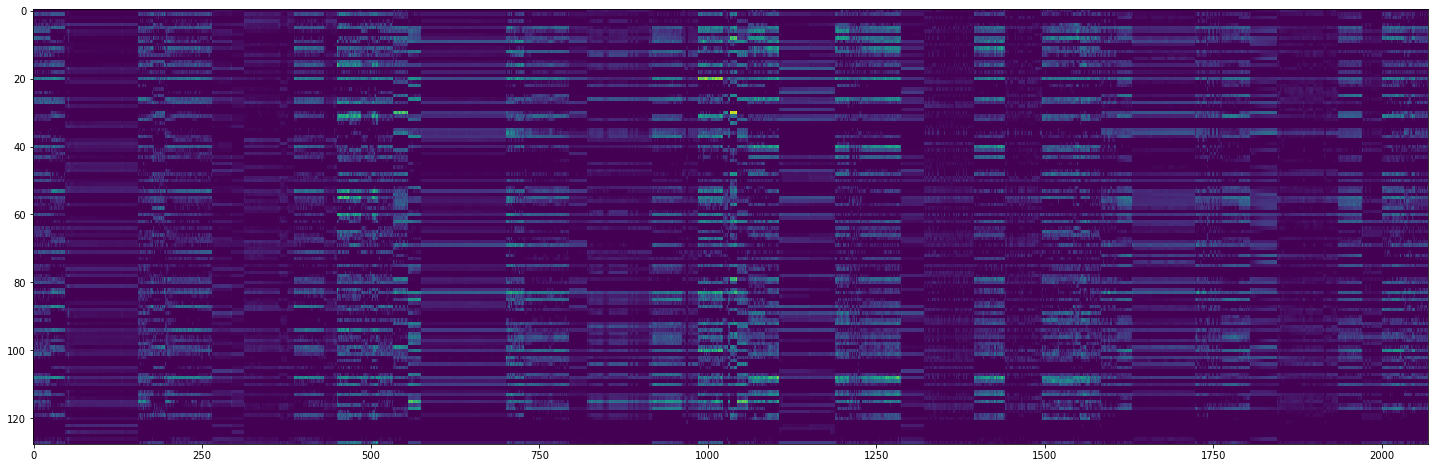

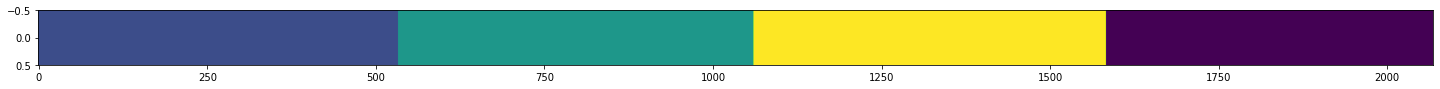

In [ ]:
plt.figure(figsize=(25, 8))
plt.imshow(test_fingerprints.T, aspect='auto', interpolation='nearest')

plt.figure(figsize=(25, 1))
plt.imshow(np.expand_dims(p_labels, 0), aspect='auto')

^ It seems that some patterns are there but let's test it with TSNE, a handy unsupervised visualization tool.

In [ ]:
from sklearn.manifold import TSNE

TSNE *(t-distributed stochastic neighbor embedding)* is dimensionality reduction method that transforms high-dimensional input into a two or three-dimensional output in such a way that similar high-dimensional inputs are projected to nearby points and dissimilar objects are projected to distant points.

In [ ]:
fingerprints_2D = TSNE(n_components=2, verbose=True, metric='cosine').fit_transform(test_fingerprints)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2069 samples in 0.001s...
[t-SNE] Computed neighbors for 2069 samples in 0.103s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2069
[t-SNE] Computed conditional probabilities for sample 2000 / 2069
[t-SNE] Computed conditional probabilities for sample 2069 / 2069
[t-SNE] Mean sigma: 0.027198
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.405457
[t-SNE] KL divergence after 1000 iterations: 0.325866


If a fingerprint really captures some kind of a fingerprint of a person, we should see clusters of the same colors as TSNE projected similar inputs to close points.

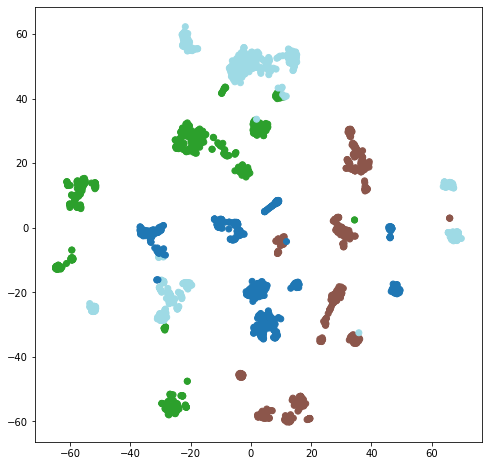

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(fingerprints_2D[:,0], fingerprints_2D[:,1], c=p_labels, cmap='tab20')

And it seems that we have a signal there. We definitely can see clusters of the same color forming in the fingerprint space. 

There is still a lot of space for improvement but even with this simple first try we have a half of the problem almost solved i.e. if two fingerprints are close together (according to the cosine metric) then it's highly probable they are from the same person.

The other half of the problem (two distant point are two different people) is not solved - we have multiple clusters of the same color.

In [ ]:
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

self_distances = []
other_distances = []

sims = cosine_similarity(test_fingerprints)

for i, j in combinations(range(len(test_fingerprints)), 2):        
    (self_distances if p_labels[i] == p_labels[j] else other_distances).append(sims[i, j])


Finally let's visualize distibutions of cosine similarity between test samples of the same patricipant versus the others. This should give us a prove of the statement above and let us chose the best similarity threshold:

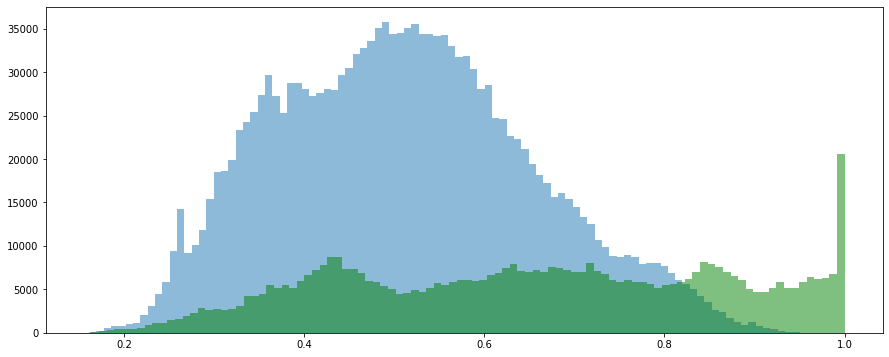

In [ ]:
plt.hist(other_distances, bins=100, alpha=0.5)
plt.hist(self_distances, bins=100, color='green', alpha=0.5)
plt.show()